In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

sample_submission_v2.csv
test-jpg-v2
test-tif-v3
test_v2_file_mapping.csv
train-jpg
train-tif-v2
train_v2.csv



In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pal = sns.color_palette()

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [3]:
df_train = pd.read_csv('../input/train_v2.csv')
df_train.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [4]:
labels = df_train['tags'].apply(lambda x: x.split(' '))

In [5]:
# Build list with unique labels
label_list = []
for label in labels:
    if label not in label_list:
        label_list.append(label)
print(label_list)

[['haze', 'primary'], ['agriculture', 'clear', 'primary', 'water'], ['clear', 'primary'], ['agriculture', 'clear', 'habitation', 'primary', 'road'], ['haze', 'primary', 'water'], ['agriculture', 'clear', 'cultivation', 'primary', 'water'], ['agriculture', 'clear', 'cultivation', 'primary'], ['agriculture', 'clear', 'cultivation', 'primary', 'road'], ['agriculture', 'clear', 'primary', 'slash_burn', 'water'], ['clear', 'primary', 'water'], ['cloudy'], ['partly_cloudy', 'primary'], ['agriculture', 'clear', 'primary', 'road'], ['clear', 'primary', 'road', 'water'], ['conventional_mine', 'partly_cloudy', 'primary'], ['agriculture', 'partly_cloudy', 'primary', 'water'], ['clear', 'cultivation', 'primary'], ['agriculture', 'cultivation', 'partly_cloudy', 'primary'], ['agriculture', 'clear', 'primary'], ['bare_ground', 'haze'], ['bare_ground', 'clear', 'habitation', 'primary'], ['agriculture', 'clear', 'habitation', 'primary', 'road', 'water'], ['partly_cloudy', 'primary', 'road', 'water'], [

In [6]:
labels_df=df_train
# Build list with unique labels
label_list = []
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)

In [7]:

for label in label_list:
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
# Display head
labels_df.head()

,image_name,tags,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
0,train_0,haze primary,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,train_1,agriculture clear primary water,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,train_2,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,train_3,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,train_4,agriculture clear habitation primary road,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0


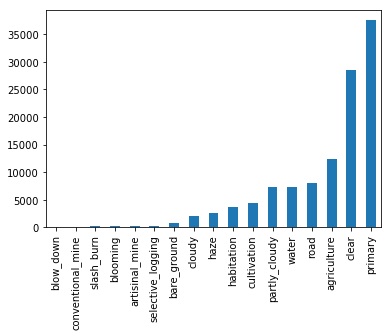

In [8]:
# Histogram of label instances
labels_df[label_list].sum().sort_values().plot.bar()

In [9]:
from sklearn.preprocessing import MultiLabelBinarizer
#Binarize labels y, prepare for model

lb = MultiLabelBinarizer()
df_train['split_tags'] = df_train['tags'].map(lambda row: row.split(" "))
y = lb.fit_transform(df_train['split_tags'])
print(y[:5,:], lb.classes_)

[[0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1]
 [0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0]] ['agriculture' 'artisinal_mine' 'bare_ground' 'blooming' 'blow_down'
 'clear' 'cloudy' 'conventional_mine' 'cultivation' 'habitation' 'haze'
 'partly_cloudy' 'primary' 'road' 'selective_logging' 'slash_burn' 'water']


In [10]:
# Resize jpg to rescaled_dim 
rescaled_dim = 64
X = np.squeeze(np.array([cv2.resize(plt.imread('../input/train-jpg/{}.jpg'.format(name)), (rescaled_dim, rescaled_dim), cv2.INTER_LINEAR).reshape(1, -1) for name in df_train['image_name'].values]))
print(X.shape,y.shape)

(40479, 16384) (40479, 17)


In [11]:
dim=64
Xc=X.reshape(-1,dim,dim,4)
print(Xc.shape)

(40479, 64, 64, 4)


In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xc, y, test_size=0.3)

In [13]:
#stanford model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
model2 = Sequential()
input_shape=Xc.shape[1:]

model2.add(BatchNormalization(input_shape=input_shape))
        
model2.add(Conv2D(32, kernel_size=(3, 3),strides=1, activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(64, kernel_size=(4, 4),strides=1, activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Flatten())
model2.add(Dense(128, activation='relu'))

model2.add(Dropout(0.5))
model2.add(Dense(17, activation='sigmoid'))

Using TensorFlow backend.


In [14]:
from keras import optimizers
opt=optimizers.Adam(lr=0.001)

In [15]:
model2.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [17]:
fitting=model2.fit(X_train, y_train, epochs=15, batch_size=64,validation_split=0.1)

Train on 25501 samples, validate on 2834 samples
Epoch 1/15
25501/25501 [==============================] - 240s - loss: 0.2235 - acc: 0.9155 - val_loss: 0.4498 - val_acc: 0.9065
Epoch 2/15
25501/25501 [==============================] - 223s - loss: 0.1831 - acc: 0.9302 - val_loss: 0.1591 - val_acc: 0.9378
Epoch 3/15
25501/25501 [==============================] - 240s - loss: 0.1696 - acc: 0.9348 - val_loss: 0.1538 - val_acc: 0.9400
Epoch 4/15
25501/25501 [==============================] - 237s - loss: 0.1611 - acc: 0.9377 - val_loss: 0.1434 - val_acc: 0.9430
Epoch 5/15
25501/25501 [==============================] - 236s - loss: 0.1536 - acc: 0.9398 - val_loss: 0.1411 - val_acc: 0.9436
Epoch 6/15
25501/25501 [==============================] - 234s - loss: 0.1500 - acc: 0.9412 - val_loss: 0.1367 - val_acc: 0.9456
Epoch 7/15
25501/25501 [==============================] - 240s - loss: 0.1452 - acc: 0.9426 - val_loss: 0.1364 - val_acc: 0.9460
Epoch 8/15
25501/25501 [========================

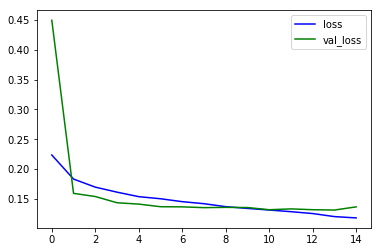

In [21]:
plt.plot(fitting.history['loss'],'b',label='loss')
plt.plot(fitting.history['val_loss'],'g',label='val_loss')
plt.legend()

In [22]:
y_pred=model2.predict(X_test)

In [23]:
from sklearn.metrics import fbeta_score
def f2_score(y_true, y_pred):
    y_true, y_pred, = np.array(y_true), np.array(y_pred)
    return fbeta_score(y_true, y_pred, beta=2, average='samples')


def find_f2score_threshold(y_pred, y_true):
    best = 0
    best_score = -1
    totry = np.arange(0,1,0.005)
    for t in totry:
        score = f2_score(y_true, y_pred > t)
        if score > best_score:
            best_score = score
            best = t
    return best

In [24]:

print(fbeta_score(y_test, np.array(y_pred) > find_f2score_threshold(y_pred, y_test), beta=2, average='samples'))

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in samples with no predicted labels.



0.881129904647


In [25]:
pred_label = (y_pred > find_f2score_threshold(y_pred, y_test))*1.0        # before multiplying by 1.0, this appears as an array of True and False
pred_labels = np.array(pred_label, np.uint8)

print(len(pred_labels),len(y_test))

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in samples with no predicted labels.



12144 12144


In [26]:
p_sum=[]
for i in range(17):
    p_sum.append(pred_labels[:,i].sum())
print(p_sum)

[5146, 109, 207, 8, 0, 9420, 769, 1, 2532, 1805, 1460, 2401, 11915, 3776, 12, 0, 4408]


In [27]:
y_sum=[]
for i in range(17):
    y_sum.append(y_test[:,i].sum())
print(y_sum)

[3696, 78, 264, 99, 32, 8614, 627, 25, 1335, 1074, 766, 2136, 11262, 2370, 101, 57, 2226]


In [28]:
error_list=[]
for i in range(17):
    error_list.append(p_sum[i]-y_sum[i])

print(np.vstack((error_list,lb.classes_)))

[[1450.0 31.0 -57.0 -91.0 -32.0 806.0 142.0 -24.0 1197.0 731.0 694.0 265.0
  653.0 1406.0 -89.0 -57.0 2182.0]
 ['agriculture' 'artisinal_mine' 'bare_ground' 'blooming' 'blow_down'
  'clear' 'cloudy' 'conventional_mine' 'cultivation' 'habitation' 'haze'
  'partly_cloudy' 'primary' 'road' 'selective_logging' 'slash_burn' 'water']]


In [30]:
error=np.vstack((error_list,lb.classes_))

['agriculture' 'artisinal_mine' 'bare_ground' 'blooming' 'blow_down'
 'clear' 'cloudy' 'conventional_mine' 'cultivation' 'habitation' 'haze'
 'partly_cloudy' 'primary' 'road' 'selective_logging' 'slash_burn' 'water']


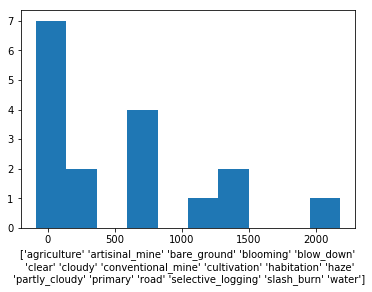

In [35]:
import matplotlib
matplotlib.pyplot.hist(error[0])
plt.xlabel(lb.classes_,)
print(lb.classes_)

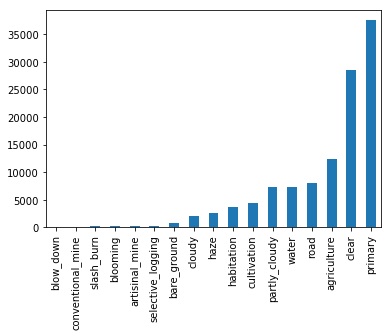

In [33]:
# Histogram of label instances
labels_df[label_list].sum().sort_values().plot.bar()

In [36]:
pred_labels1=lb.inverse_transform(pred_labels)
p_labels=[]
for i in range(0,len(pred_labels1)):
    p_labels.append(' '.join(pred_labels1[i]))

In [38]:
print(p_labels)

['agriculture clear cultivation haze primary road', 'clear primary', 'clear haze primary', 'clear primary water', 'agriculture clear cultivation habitation primary road water', 'agriculture cultivation partly_cloudy primary', 'clear primary', 'agriculture clear cultivation primary water', 'partly_cloudy primary', 'agriculture clear cultivation habitation primary road water', 'agriculture clear cultivation primary road water', 'clear primary', 'agriculture clear cultivation primary road water', 'clear primary', 'agriculture artisinal_mine clear cultivation habitation primary road water', 'cloudy partly_cloudy primary water', 'clear primary', 'partly_cloudy primary', 'clear primary', 'clear primary', 'agriculture clear cultivation primary road water', 'clear primary', 'agriculture clear cultivation haze partly_cloudy primary road water', 'agriculture clear cultivation habitation primary road water', 'partly_cloudy primary', 'clear primary', 'agriculture clear cultivation partly_cloudy pr

In [39]:
y_test1=lb.inverse_transform(y_test)
y_labels=[]
for i in range(0,len(y_test1)):
    y_labels.append(' '.join(y_test1[i]))

**Test to Submission**

In [ ]:
df_test_data['tags'] = ''

In [ ]:
test_label = (test_pred > find_f2score_threshold(y_pred, y_test))*1.0        # before multiplying by 1.0, this appears as an array of True and False
test_labels1 = np.array(test_label, np.uint8)

print(test_labels1)

In [ ]:
print(len(test_labels1))

In [ ]:
test_labels=lb.inverse_transform(test_labels1)

In [ ]:
t_labels=[]
for i in range(0,len(test_labels)):
    t_labels.append(' '.join(test_labels[i]))

In [ ]:
df_test_data['tags'] = t_labels
df_test_data.to_csv('submission.csv', index=False)


In [ ]:
print(check_output(["ls", "../working"]).decode("utf8"))